<a href="https://colab.research.google.com/github/ahluwalij/BigThink_AI_Fall_2022/blob/main/Malaria_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

**Welcome!**

Hey, there! Welcome to BigTh!nk AI's final project. We are going to go through how you can run this project yourself! There's some reading to do along the way, but it's going to be fun and worth it at the end!

**Runtime Instructions**

Remember, this environment divides all your code into cells.

1. Connect to a Google server, top right. Wait for it to say "Connected".
2. Go to "Runtime", top left. Select "Change runtime type" and set it to GPU.
3. Click the `[ ]` on the left of each code cell to run it. Or just hit "Runtime" and select "Restart and run all" if you need.

**Note:** If you run a cell, but modify something in a cell above it, then to avoid errors, you have to rerun every cell from and including the cell you modified.

**Note:** If your syntax and tensor dimensions are correct but you're still getting an error, go to "Runtime" at the top left of this Colab and select "Restart and run all".

In [1]:
from google.colab import drive # ADD TEXT ABOVE
drive.mount('/content/drive')

Mounted at /content/drive


Here are some libraries you'll see very often in machine learning and deep learning. Remember, importing TensorFlow implicitly imports Keras! Go ahead and run this cell below with the imports. It'll take a minute.

In [2]:
import tensorflow as tf # our favorite AI framework!
# Note that keras is imported by default, so we'll often call tf.keras.<command>

import math
import numpy as np # the fundamental building block of ML: arrays!
import matplotlib.pyplot as plt # this will help us plot and visualize our data
import logging
import seaborn as sns # this will help us in understanding performance metrics towards the end

!pip install -U tensorflow_datasets # we're getting the repository of datasets that this project's dataset belongs to

import tensorflow_datasets as tfds 
tfds.disable_progress_bar()

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. The Problem

**Issue**

It's 2021 and there's a new malaria outbreak! People in Yew Nork City are shivering in fever and chills! It's up to you, the AI engineers at BigTh!nk BioTech (established after the famous coronavirus pandemic of 2020) to speed up diagnoses.

With patients storming hospitals, we need a way to make testing incredibly rapid and accurate - and the current methods are far too slow. We need you, and we need the power of AI.

**Task**

Your job is to make a model that can learn from previous images to identify a malaria-infected cell. By the end of this project, given an image of a cell, your model's prediction must be one of two outputs:

0: Uninfected

1: Parasitized

**Supervised Learning**

Remember, a supervised learning AI will look at many input examples (images), look at what the output actually was (labels) for those input examples, and then try to figure out what the link is. 

Once it learns that, it will try to predict the output of an unseen, previously unknown input datapoint (a new image).


# 3. The Raw Data

The hospitals of Yew Nork City have compiled 27,558 cell images from thin blood smear slide images. If you're not sure what that is, don't worry! It's just a way to take pictures of microscopic cells. These pictures are what you'll train your algorithm on to identify which ones are parasitized.

Go ahead and run these code cells below to load the dataset and divide it into a training dataset, `train_ds`, and a test dataset, `test_ds`.

Here's our split:

`train_ds`: 70% | `test_ds`: 30%

In [3]:
ds, info = tfds.load('malaria', split = 'train', shuffle_files = True, with_info = True)

train_ds, test_ds = tfds.load(
  'malaria',
  split = ['train[:70%]', 'train[70%:]'],
  shuffle_files = True, as_supervised = True,
)

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Run this cell to see exactly how many images are in each of our two datasets!

In [5]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Number of training images: " + str(NUM_TRAIN_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Number of testing images: " + str(NUM_TEST_IMAGES))

Number of training images: 19291
Number of testing images: 8267


Running this cell below will show you some examples of raw, unprocessed images of our patients' cells and their labels:

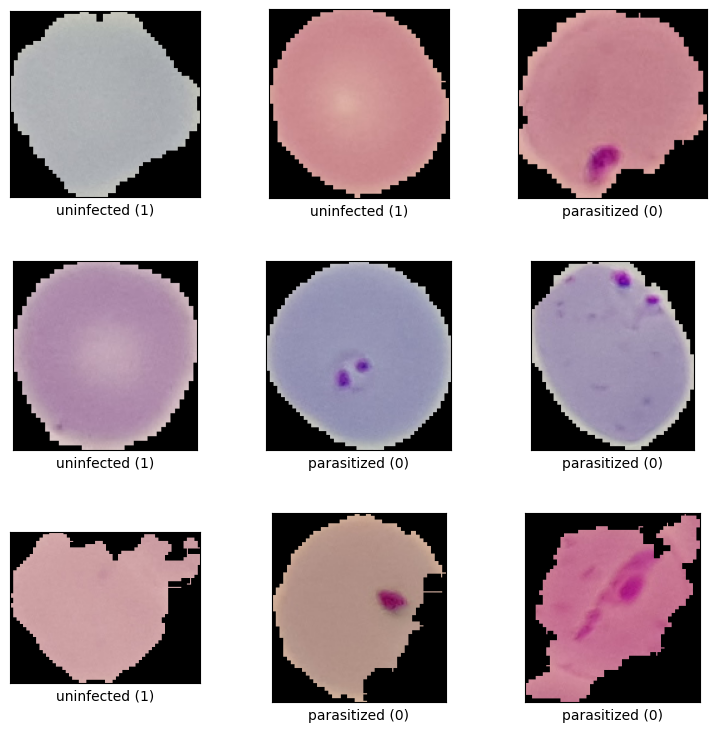

In [6]:
vis = tfds.visualization.show_examples(ds, info)

Take a look at the labels of the images above. The labels in this raw dataset are unintuitive. Currently, the labels are:

0: parasitized

1: uninfected

"*A tragedy! Not intuitive at all! Where is the concern?*" - unknown source

We're going to invert these in **4. Processing the Data**, so that the labels will *later* be:

0: uninfected

1: parasitized



If you take yet another look at the pictures above, you might notice the images aren't evenly sized.

Running the cell below can show you what we mean by uneven image size.

In [7]:
for image, label in train_ds.take(3):
    print("Image size: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image size:  (103, 103, 3)
Label:  1
Image size:  (145, 148, 3)
Label:  1
Image size:  (133, 127, 3)
Label:  1


If the output above is something like:

`Image size: (140, 120, 3)`

it just means the image is 140 x 120 pixels, and the 3 tells you how many color channels are in the image. There are 3 here, which are red, green, and blue (RGB). Pixel stuff.

# 4. Processing the Data

If you're supposed to build an AI to learn well from these images, you need some cleaner data! It makes it easier on whatever model you build to learn. Don't worry, we're handling this part for you! Just go ahead and run this cell below.

We're doing two things:

* Standardizing image sizes to 200 x 200 pixels
* Inverting labels to be 0 for uninfected, 1 for parasitized

This cell defines a couple of standard constants we want, as well as 3 functions we've written to clean the data. It'll call those functions on `train_ds` and `test_ds` to create `clean_train_ds` and `clean_test_ds`.

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

def convert(image, label): # this will be called by the next function, pad
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label): # resizing each image to 200 x 200
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image, label

def invert_labels(image, label):
    return image, 1 - label

clean_train_ds = (
    train_ds
    .map(pad)
    .map(invert_labels)
)

clean_test_ds = (
    test_ds
    .map(pad)
    .map(invert_labels)
) 

# 5. The Clean Data

Run this cell below and look how clean these examples are! All the cell pictures have been padded and fit into images that are 200 x 200 pixels. These are ready to be read by your model.

As you might have noticed in the cell above, the names of the clean training and testing datasets are `clean_train_ds` and `clean_test_ds`. We're going to use Matplotlib to visualize our changes to the data.

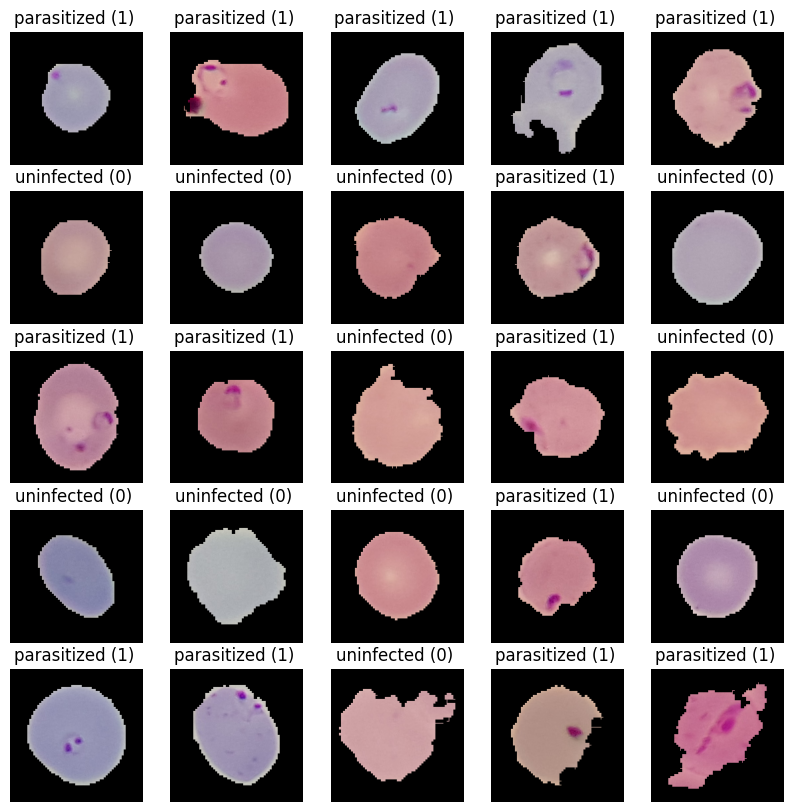

In [9]:
image_batch, label_batch = next(iter(clean_train_ds.batch(BATCH_SIZE)))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("parasitized (1) ")
        else:
            plt.title("uninfected (0) ")
        plt.axis("off")
show_batch(image_batch.numpy(), label_batch.numpy())

Looks like the labels are indeed fixed! 0 now means uninfected, and 1 now means parasitized.

Don't worry about this little cell below, just run it. We're just getting the data in batches to be sent to the model for training and testing.

In [10]:
clean_train_ds = clean_train_ds.repeat().shuffle(NUM_TRAIN_IMAGES).batch(BATCH_SIZE)
clean_test_ds = clean_test_ds.batch(BATCH_SIZE)

# 6. The Model

**Your Job**

Phew! We're finally here. Your job is to create and optimize a CNN model to identify malaria in a cell. As a re-statement: the model should produce 0 on an uninfected cell image and 1 on a parasitized cell image.

**Convolutional Neural Networks (CNNs)**

To detect malaria, we need some way to *see* the cells! In computer vision, this is commonly achieved through CNNs. A flashlight in the dark, seeing part by part until it pieces the picture together.

We're writing the convolutional part of the network. **Don't change it!** 

Write your part of the model under `# BUILD YOUR PART HERE`, and run the cell.
`model.summary()` will give you a good idea of your finished network.

**Output**

**Do not modify the output layer.** It needs to be 1 neuron with a sigmoid activation function, because this problem is a binary classification problem (only two outputs, 0 or 1). Don't worry about rounding anything, Keras does all that internally.

**Hyperparameters**

Remember, *parameters* are what the model adjusts by itself. *Hyperparameters* are what *you* can build and adjust in the model to maximize performance. In this project, you're free to change any or all of the following:



*   Depth of neural network (number of dense layers except output)
*   Width of neural network (number of neurons per dense layer except output)
*   Activation function of each dense layer (except output)

You *can* also change the following, but we'll get to these two in **7. Compiling the Model**.

*   Optimization algorithm
*   Learning rate

Hint: you might find this useful. [Keras Sequential Model](https://keras.io/guides/sequential_model/). Remember to prefix layers with `tf.keras.`!

Go save Yew Nork City!

No pressure.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])


model.summary() # this is going to print a quick little summary of our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 2)                 1

# 7. Compiling the Model

There are three parts to the `model.compile()` function: `optimizer`, `loss`, and `metrics`. While you're only supposed to change the `optimizer` (and learning rate) in this project, we're going to explain them all.

**Optimizer**

You are free to set an optimizer you think works best! You can find a list of [Keras optimizers here](https://keras.io/api/optimizers/) if you scroll down to the "Available Optimizers" heading.

Remember, setting an optimizer can be done either by passing a string, like 

`optimizer = 'RMSProp'`

or by calling a function from `tf.keras`. For example, 

`optimizer = tf.keras.optimizers.RMSProp()`. 

We recommend the latter, since you can set `learning_rate` as a parameter of the function, like 

`optimizer = tf.keras.optimizers.RMSProp(learning_rate = 0.1)`

(Hint: don't just settle for RMSProp!)

**Note:** If you do not explicitly set a `learning_rate` value, it'll go by the default value listed in the documentation. Default `learning_rate` values can be found on that optimizer's documentation ([click here](https://keras.io/api/optimizers/)).

**Loss Function**

We've set the model to use the `BinaryCrossentropy()` loss function, commonly used in binary classifiers. The model adjusts its parameters (weights and biases) to minimize this loss. **Don't change this!**

Remember, the lower the loss, the better!

**Metrics**

Loss is fine to understand if the model is learning. But in the real world, a common way to test is called the **confusion matrix**. We'll get to this in **9. Performance on Test Data**, but basically, it has four metrics we calculate, given by the bullets below. And you can check this link for all possible [performance metrics on Keras](https://keras.io/api/metrics/). **Don't modify this part of the function!**

Here are the metrics that will help us measure your models' performance.

*   `TruePositives` (guess correct, guessed 1)
*   `TrueNegatives` (guess correct, guessed 0)
*   `FalsePositives` (guess wrong, guessed 1)
*   `FalseNegatives` (guess wrong, guessed 0)

In [12]:
model.compile(
    optimizer='RMSProp',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



# 8. Training

**Epochs and Batches**

When you read a chapter in a book, that's basically a *batch*. When you read the book end to end once, that's basically an *epoch*. 

The same way, when a model reads a group of (in this case) 32 examples, it's a batch. That's `BATCH_SIZE = 32`, which we defined at the start of **4. Processing the Data**. When a model reads through all of the training examples once, it's an epoch. That's `NUMBER_OF_EPOCHS = 5` here, meaning 5 epochs. **Don't change `NUMBER_OF_EPOCHS`!**

`steps_per_epoch` is just a calculation of how many batches there are per epoch.

**Beginning Training**

The `model.fit()` function from Keras begins to train the model and tweak its parameters (weights and biases).
Run this cell below to begin the actual training process for the model. You will see a progress bar, followed by the `loss` value and the number of `true_positives`, `true_negatives`, `false_negatives`, and `false_positives` in that epoch.

Running the `model.fit()` function once can take around 3-4 minutes on the GPU setting.

In [13]:
NUMBER_OF_EPOCHS = 5

model.fit(
    clean_train_ds,
    epochs=NUMBER_OF_EPOCHS,
    steps_per_epoch=math.ceil(NUM_TRAIN_IMAGES / BATCH_SIZE)
)


Epoch 1/5
603/603 [==============================] - 37s 25ms/step - loss: 0.6636 - accuracy: 0.6244
Epoch 2/5
603/603 [==============================] - 15s 24ms/step - loss: 0.4494 - accuracy: 0.8297
Epoch 3/5
603/603 [==============================] - 15s 24ms/step - loss: 0.3645 - accuracy: 0.8919
Epoch 4/5
603/603 [==============================] - 16s 27ms/step - loss: 0.3249 - accuracy: 0.9108
Epoch 5/5
603/603 [==============================] - 15s 25ms/step - loss: 0.2741 - accuracy: 0.9191


After 5 epochs, your model has tuned its weights and biases in a certain configuration.

# 9. Performance on Test Data

Loss is fine, but it doesn't show us the whole picture. And looking at the confusion matrix as numbers doesn't *show* us what's going on. So we're going to actually calculate the accuracy of your model from a visualized confusion matrix!

To do that, first we need to test your model on data that it hasn't yet seen or trained on. Remember when we split the dataset into 70% for `train_ds` and 30% for `test_ds`? We're testing on the cleaned version of `test_ds` which we named `clean_test_ds`. Test data is also called *unseen data*.

**Beginning Testing**

Run your model on the test data with this cell below.


In [17]:
test_loss, test_accuracy = model.evaluate(clean_test_ds, steps=math.ceil(NUM_TEST_IMAGES / BATCH_SIZE))

259/259 [==============================] - 5s 17ms/step - loss: 0.4101 - accuracy: 0.8455


Using the Seaborn library we imported, we're going to draw the confusion matrix for your model to assess its performance on the test data!

Running these 2 cells below will build the confusion matrix for your model's performance on `clean_test_ds`.

In [18]:
def draw_confusion_matrix(tp, tn, fp, fn):
  cf_matrix = np.array([[tp, fp], [fn, tn]])
  group_names = ['True Pos','False Pos','False Neg','True Neg']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues', xticklabels = False, yticklabels = False)

In [21]:
from sklearn.metrics import confusion_matrix

# Initialize variables for confusion matrix values
tn, fp, fn, tp = 0, 0, 0, 0

# Iterate over the test dataset and compute metrics
for images, labels in clean_test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    tn_, fp_, fn_, tp_ = confusion_matrix(labels, predicted_labels).ravel()
    tn += tn_
    fp += fp_
    fn += fn_
    tp += tp_

# Display the confusion matrix
confusion_matrix_values = np.array([[tn, fp], [fn, tp]])
print("Confusion Matrix:")
print(confusion_matrix_values)


1/1 [==============================] - 0s 64ms/step
Confusion Matrix:
[[3428  701]
 [ 576 3562]]


Now, we can actually calculate the accuracy from the confusion matrix. Remember,

**Accuracy = (Total Trues) / (Total Predictions)**

Run the cell below to see the accuracy of your model on the test data!

In [23]:
accuracy_metric = tf.keras.metrics.Accuracy()
for images, labels in clean_test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy_metric.update_state(labels, predicted_labels)

accuracy = accuracy_metric.result().numpy()

1/1 [==============================] - 0s 21ms/step


In [24]:
print("The accuracy of our model is %.7f, or about %d%%." % (accuracy, round(accuracy*100)))
if accuracy >= 0.95:
    print("Great job! Our high-accuracy AI is about to save Yew Nork City in style.")
elif accuracy > 0.9:
    print("Good job! Our model is going to do a great job of helping Yew Nork City.")
elif accuracy > 0.8:
    print("Not bad! Our model is going to prove fairly useful to Yew Nork City.")
else:
    print("Good effort, but Yew Nork City needs at least 80% test accuracy in order to diagnose patients accurately.")


The accuracy of your model is 0.8455305, or about 85%.
Not bad! Your model is going to prove fairly useful to Yew Nork City.


# 10. Conclusion

If our model did better than 80%, BigTh!nk's AI engineers really mean business. Yew Nork City is eternally indebted to your service to its ailing civilians!

You can also go through the specific data processing functions in detail, if you'd like. 

Here are some documentation links if you want to learn more about the libraries, functions, and tools you (knowingly or unknowingly) used in this project!

*   [Malaria Dataset](https://www.tensorflow.org/datasets/catalog/malaria)
*   [TensorFlow](https://www.tensorflow.org/guide)
*   [Keras](https://keras.io/api/)
*   [Seaborn](https://seaborn.pydata.org/)
*   [Numpy](https://numpy.org/)
*   [Matplotlib](https://matplotlib.org/)